# TF AE

In [1]:
%run utils.ipynb

In [2]:
import pandas as pd
import numpy as np
import os
import sys
# from utils import *
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
# import dill

In [3]:
import sklearn
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, top_k_accuracy_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, FunctionTransformer, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline, make_pipeline

In [95]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Dropout, Activation, Input, Embedding, TextVectorization, Reshape, Add, Concatenate, Flatten, Conv1D, Conv1DTranspose, BatchNormalization
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError

In [58]:
import keras.backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [5]:
_, seg_df = load_user_data()
print(seg_df.shape)
y = pd.read_csv('challengeToFill.csv').drop(columns=['Unnamed: 0']).T.reset_index(drop=True).T
y_train = y.iloc[:LABELED_USERS, :TRAIN_SEG]
y_test_df = y.iloc[:LABELED_USERS, TRAIN_SEG:]
train_df = seg_df.iloc[:LABELED_USERS, :TRAIN_SEG]
test_df = seg_df.iloc[:LABELED_USERS, TRAIN_SEG:]
submission_df = seg_df.iloc[LABELED_USERS:, TRAIN_SEG:]
sentences = train_df.to_numpy().flatten().tolist()
# embedding_model = create_embeddings(sentences, vector_size=EMBEDDING_DIM, window=5)
# print(embedding_model.wv)
print(train_df.shape)
print(test_df.shape)

(40, 150)
(10, 50)
(10, 100)


In [6]:
all_commands = np.unique(seg_df.to_numpy().flatten().tolist()).tolist()

In [7]:
train = train_df.to_numpy().flatten()
test = test_df.to_numpy().flatten()
train.shape, test.shape

((500,), (1000,))

In [9]:
EMBEDDING_DIM = 128

In [63]:
s = pd.Series(train_df.to_numpy().flatten()).apply(lambda x: ' '.join(x)).values.reshape(-1, 1).tolist()
text_dataset = tf.data.Dataset.from_tensor_slices(s)
vectorize_layer = TextVectorization(output_mode='int', output_sequence_length=SEG_SIZE)
vectorize_layer.adapt(text_dataset.batch(64))

In [106]:
def build_encoder():
    return Sequential([ BatchNormalization(),
                        Dense(EMBEDDING_DIM*4, activation='relu'),
                        Conv1D(64, 5, activation='relu'),
                        Dense(EMBEDDING_DIM*2, activation='relu'),
                        Conv1D(32, 3, activation='relu'),
                        Dense(EMBEDDING_DIM)
    ], name='encoder')

In [107]:
encoder = build_encoder()
encoder.build(input_shape=(None, SEG_SIZE))
encoder.summary()

ValueError: Input 0 of layer conv1d is incompatible with the layer: : expected min_ndim=3, found ndim=2. Full shape received: (None, 512)

In [98]:
def build_decoder():
    return Sequential([ Conv1DTranspose(32, 3, activation='relu'),
                        Dense(EMBEDDING_DIM*2, activation='relu'),
                        Conv1DTranspose(64, 5, activation='relu'),
                        Dense(EMBEDDING_DIM*4, activation='relu'),
                        BatchNormalization()
                        Dense(SEG_SIZE)
    ], name='decoder')

In [99]:
decoder = build_decoder()
decoder.build(input_shape=(None, EMBEDDING_DIM))
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_40 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_41 (Dense)             (None, 100)               51300     
Total params: 215,908
Trainable params: 215,908
Non-trainable params: 0
_________________________________________________________________


In [100]:
autoencoder = Sequential(name='autoencoder')
autoencoder.add(encoder)
autoencoder.add(decoder)
autoencoder.build(input_shape=encoder.input_shape)
autoencoder.compile(loss=root_mean_squared_error, optimizer='adam', metrics=RootMeanSquaredError(name='rmse'))
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 128)               216336    
_________________________________________________________________
decoder (Sequential)         (None, 100)               215908    
Total params: 432,244
Trainable params: 432,044
Non-trainable params: 200
_________________________________________________________________


In [121]:
cp = ModelCheckpoint('model.h5', save_best_only=True, verbose=1, save_weights_only=True)
es = EarlyStopping(monitor="val_loss", patience=100, mode="min", verbose=1)
rlop = ReduceLROnPlateau(patience=30, verbose=2)
callbacks = [cp, es, rlop]

In [102]:
train.shape

TensorShape([500, 100])

In [103]:
user_1 = train[:TRAIN_SEG, :].numpy().astype(float)
user_1

array([[  7.,  19.,  19., ..., 116.,   2.,   2.],
       [116.,   5.,   5., ...,  15.,  13.,  21.],
       [ 21.,  72.,  15., ..., 187.,  21.,  21.],
       ...,
       [ 52.,  52.,  56., ...,  72.,  15.,  15.],
       [ 13.,   5.,  76., ...,  79.,  12., 119.],
       [130.,   2.,  18., ...,  18.,  79.,  12.]])

In [104]:
history = autoencoder.fit(user_1, user_1, batch_size=1, epochs=500, validation_split=0.2, callbacks=callbacks)

Epoch 1/500
40/40 [==============================] - 1s 9ms/step - loss: 55.0726 - rmse: 57.9179 - val_loss: 63.5718 - val_rmse: 65.1263

Epoch 00001: val_loss improved from inf to 63.57179, saving model to model.h5
Epoch 2/500
40/40 [==============================] - 0s 5ms/step - loss: 55.0549 - rmse: 57.9014 - val_loss: 63.8619 - val_rmse: 65.4396

Epoch 00002: val_loss did not improve from 63.57179
Epoch 3/500
40/40 [==============================] - 0s 4ms/step - loss: 55.0371 - rmse: 57.8844 - val_loss: 64.3884 - val_rmse: 66.0012

Epoch 00003: val_loss did not improve from 63.57179
Epoch 4/500
40/40 [==============================] - 0s 4ms/step - loss: 55.0193 - rmse: 57.8671 - val_loss: 65.2088 - val_rmse: 66.8751

Epoch 00004: val_loss did not improve from 63.57179

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/500
40/40 [==============================] - 0s 4ms/step - loss: 55.0093 - rmse: 57.8581 - val_loss: 66.4524 - val_rmse: 68.

In [122]:
# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
    
    """
    Parameters
    ----------
    output_units: int
    Number of output units

    code_size: int
    Number of units in bottle neck
    """

    def __init__(self, output_units, hidden_dim=32, code_size=8):
        super().__init__()
        self.encoder = Sequential([
            # Embedding(vectorize_layer.vocabulary_size(), EMBEDDING_DIM),
            # LSTM(hidden_dim, return_sequences=True, dropout=0.5),
            Dense(hidden_dim, activation='relu'),
            Dropout(0.3),
            Dense(hidden_dim//2, activation='relu'),
            Dropout(0.2),
            Dense(hidden_dim//4, activation='relu'),
            Dropout(0.1),
            # Dropout(0.1),
            # Dense(16, activation='relu'),
            # Dropout(0.1),
            # Dense(code_size, activation='relu')
            ], name='encoder')
        
        self.decoder = Sequential([
            Dense(hidden_dim//4, activation='relu'),
            Dropout(0.1),
            Dense(hidden_dim//2, activation='relu'),
            Dropout(0.2),
            Dense(hidden_dim, activation='relu'),
            Dropout(0.3),
            Dense(output_units, activation='relu'),
            Flatten()
            ], name='decoder')

    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

In [132]:
model = AutoEncoder(output_units=SEG_SIZE, hidden_dim=32)
# configurations of model
model.compile(loss=root_mean_squared_error, metrics=RootMeanSquaredError(name='rmse'), optimizer='adam')
model.build(input_shape=(None, SEG_SIZE))
model.summary()

Model: "auto_encoder_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 8)                 1752      
_________________________________________________________________
decoder (Sequential)         (None, 100)               4060      
Total params: 5,812
Trainable params: 5,812
Non-trainable params: 0
_________________________________________________________________


In [133]:
train = train.numpy().astype(float)

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [134]:
history = model.fit(
    train,
    train,
    epochs=500,
    batch_size=4,
    validation_split=0.25,
    callbacks= callbacks
    # validation_data=(x_test_scaled, x_test_scaled)
)

Epoch 1/500
94/94 [==============================] - 1s 5ms/step - loss: 47.7730 - rmse: 49.0299 - val_loss: 51.1093 - val_rmse: 52.3817

Epoch 00001: val_loss did not improve from 43.42315
Epoch 2/500
94/94 [==============================] - 0s 3ms/step - loss: 46.3056 - rmse: 47.6796 - val_loss: 50.5032 - val_rmse: 51.7649

Epoch 00002: val_loss did not improve from 43.42315
Epoch 3/500
94/94 [==============================] - 0s 3ms/step - loss: 45.2185 - rmse: 46.4846 - val_loss: 48.4695 - val_rmse: 49.6568

Epoch 00003: val_loss did not improve from 43.42315
Epoch 4/500
94/94 [==============================] - 0s 3ms/step - loss: 43.9787 - rmse: 44.9779 - val_loss: 48.3367 - val_rmse: 49.5248

Epoch 00004: val_loss did not improve from 43.42315
Epoch 5/500
94/94 [==============================] - 0s 3ms/step - loss: 43.2523 - rmse: 44.3790 - val_loss: 47.7297 - val_rmse: 48.9148

Epoch 00005: val_loss did not improve from 43.42315
Epoch 6/500
94/94 [==============================]

In [288]:
model.load_weights('model.h5')

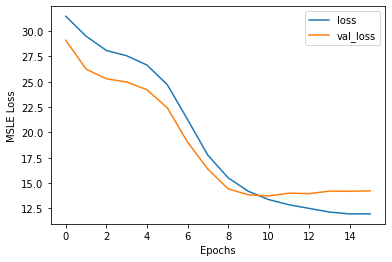

In [289]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MAE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [274]:
s_test = pd.Series(test_df.to_numpy().flatten()).apply(lambda x: ' '.join(x)).values.reshape(-1, 1).tolist()
test = vectorize_layer(s_test)
test

<tf.Tensor: shape=(1000, 100), dtype=int64, numpy=
array([[ 18,  18,  58, ...,  21,  21,   7],
       [ 18,  58,  21, ...,  21,   7,  66],
       [ 58,  21,  21, ...,   7,  66,   8],
       ...,
       [ 13,  18,   7, ...,  35,   7, 129],
       [ 18,   7,  47, ...,   7, 129, 127],
       [  7,  47,  16, ..., 129, 127, 126]], dtype=int64)>

In [290]:
def find_threshold(model, x_train):
    reconstructions = model.predict(x_train)
    # provides losses of individual instances
    reconstruction_errors = tf.keras.losses.mae(reconstructions, x_train)
    # threshold for anomaly scores
    threshold = np.mean(reconstruction_errors.numpy()) + np.std(reconstruction_errors.numpy())
    return threshold

def get_predictions(model, x_test, threshold):
    predictions = model.predict(x_test)
    # provides losses of individual instances
    errors = tf.keras.losses.mae(predictions, x_test)
    # 0 = anomaly, 1 = normal
    anomaly_mask = pd.Series(errors) > threshold
    preds = anomaly_mask.map(lambda x: 0.0 if x == True else 1.0)
    return preds

In [291]:
threshold = find_threshold(model, test)
print(f"Threshold: {threshold}")
predictions = get_predictions(model, test, threshold)
accuracy_score(predictions, y_test)

Threshold: 16.59912089482906


0.183

In [292]:
get_metrics(y_test, predictions)

Acc: 0.183
Precision: 0.09854423292273236
Recall: 0.88
F1 Score: 0.17724068479355487
Final Grade: 55.25573770491803/70


55.25573770491803

## Sklearn AE

In [299]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.parsing.preprocessing import preprocess_string
from sklearn.base import BaseEstimator
from sklearn import utils as skl_utils
from tqdm import tqdm

import multiprocessing
import numpy as np

class Doc2VecTransformer(BaseEstimator):

    def __init__(self, vector_size=100, learning_rate=0.02, epochs=20):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self._model = None
        self.vector_size = vector_size
        self.workers = multiprocessing.cpu_count() - 1

    def fit(self, df_x, df_y=None):
        tagged_x = [TaggedDocument(str(row['Plot']).split(), [index]) for index, row in df_x.iterrows()]
        model = Doc2Vec(documents=tagged_x, vector_size=self.vector_size, workers=self.workers)

        for epoch in range(self.epochs):
            model.train(skl_utils.shuffle([x for x in tqdm(tagged_x)]), total_examples=len(tagged_x), epochs=1)
            model.alpha -= self.learning_rate
            model.min_alpha = model.alpha

        self._model = model
        return self

    def transform(self, df_x):
        return np.asmatrix(np.array([self._model.infer_vector(str(row['Plot']).split())
                                     for index, row in df_x.iterrows()]))

In [316]:
doc2vec_vectors = embedding_model.wv[train_df]

In [323]:
from sklearn.neural_network import MLPRegressor

auto_encoder = MLPRegressor(hidden_layer_sizes=(
                                                 64,
                                                 16, 
                                                 64,
                                               ))
auto_encoder.fit(doc2vec_vectors, doc2vec_vectors)
predicted_vectors = auto_encoder.predict(doc2vec_vectors)

In [324]:
auto_encoder.score(predicted_vectors, doc2vec_vectors)

-5.034977812176536

<AxesSubplot:>

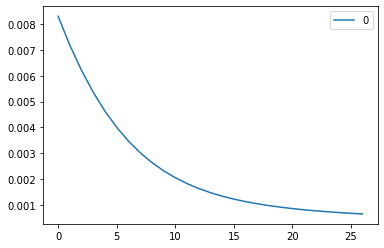

In [322]:
pd.DataFrame(auto_encoder.loss_curve_).plot()

In [ ]:
import os
import shutil

version = input()

dir_path = f'submissions\\{version}'
notebook_name = f'318443595_318949443_{version}.ipynb'
if not os.path.exists(dir_path):
    os.system(f'mkdir {dir_path}')

shutil.copyfile('Untitled.ipynb', f'{dir_path}\\{notebook_name}')
to_fill_df = pd.read_csv('challengeToFillOriginal.csv')
to_fill_df.iloc[LABELED_USERS: ,TRAIN_SEG+1:] = np.array(preds, dtype=int)
for col in to_fill_df.columns[1:]:
    to_fill_df[col] = to_fill_df[col].astype(int)
to_fill_df.to_csv(f'submissions/{version}/318443595_318949443_{version}.csv', index=False)